# UAV integrated route optimization in Cold Storage Warehouses

## Basic Details
- Researcher - Wewalage A. U. P.
- Supervisor - Prof. Amila Thibbatuwawa
- External Advisor - Ms. Kasuni Weerasinghe

## Objectives
 - RO1: Analyze impact of battery heating on UAV energy use and flight duration.
 - RO2: Simulate UAV–UGV operations under different temperature conditions.
 - RO3: Develop an ACO-based energy-aware routing algorithm for cold storage

# Problem Formation

- UAV deploy from a UGV for a aisle.
- UAV can travel to any pallet position in two racks beside the aisle.
- Each Rack contains 4 rows and 8 columns, means 32 pallet positions.
- So, There are two racks. We note them as `rack1` and `rack2`.
- Pallet Position (Cell) Notation
   - Rack 1 - 1 to 32
   - Rack 2 - 101 to 132
- 0 and 100 nodes denotes the UGV Positions and it connects to 1 and 101 respectively.

## Import necessary Libraries

In [2]:
import math
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle

That sentence is basically trying to say something simple while wearing an unnecessarily fancy suit. Here’s a clearer version in plain language:

Section 4 takes the articles that were reviewed earlier and examines them more closely. It looks at the different kinds of meta-heuristic algorithms used for UAV (drone) path planning and explains what makes each type unique and how well they work. The goal is to give a clearer picture of the strengths, weaknesses, and overall results of these optimization methods.

If you’re working on this for a report or assignment, it might help to imagine Section 4 as the “deep dive” chapter where the patterns, differences, and practical lessons from all the algorithms finally get unpacked.

## Energy Calculation

### Parameters
<table style="float: left;">
    <thead>
        <tr>
            <th>Parameter</th>
            <th>Values</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>W</td>
            <td>20N</td>
        </tr>
        <tr>
            <td>n</td>
            <td>4</td>
        </tr>
        <tr>
            <td>$ \rho $</td>
            <td><font color ='Yellow'>need to define</font></td>
        </tr>
        <tr>
            <td>A</td>
            <td>$ 0.214 m^{2} $</td>
        </tr>
        <tr>
            <td>$ C_{T} $</td>
            <td>0.001195</td>
        </tr>
        <tr>
            <td>$ \delta $</td>
            <td>0.011</td>
        </tr>
        <tr>
            <td>$ s $</td>
            <td>0.045</td>
        </tr>
        <tr>
            <td>$ k $</td>
            <td>$ 0.11 $</td>
        </tr>
        <tr>
            <td>$ v_{0} $</td>
            <td>6.325</td>
        </tr>
        <tr>
            <td>$ S_{FP||} $</td>
            <td>$ 0.009 m^{2} $</td>
        </tr>
    </tbody>  
</table>

In [3]:
#fixed Variables
w = 20
n = 4
A = 0.214
ct = 0.001195
delta=0.011
s=0.045
k=0.11
v0=6.325
sfp_h=0.009
sfp_v=0.377

#variying
rho = 1.168
vf = 1.5
va = 1
vd = 1

v_diagonal = 1
angal_to_x = math.radians(45)

### Hovering

Power consumption for <font color='yellow'>Hovering</font>:

$P_{mh} = P_{bl} + P_{in}$

$P_{bl} = \frac{\delta s}{8 \sqrt{n\rho A}} \left (\frac{W}{C_{T}} \right)^{3/2}$

$P_{in} = (1+k) \frac{W^{3/2}}{\sqrt{ 2 n\rho A}}$

In [4]:
p_bl = (delta*s) / (8 * math.sqrt(n* rho * A)) * ((w / ct)**(3/2))
p_in = (1+k)*((w ** (3/2))/math.sqrt(2 * n* rho * A))
p_mh = p_bl + p_in

print("Blade profile power (W) : ", p_bl)
print("Induced power (W) : ", p_in)
print("Hovering power (w) : ", p_mh)

Blade profile power (W) :  133.98310673620625
Induced power (W) :  70.20930447252293
Hovering power (w) :  204.1924112087292


### Forward Fight

Power consumption for <font color='yellow'>Forward flight</font>:

$P_{mf}(V) = P_{bl} + \frac{3 \delta s}{8}  \sqrt{\frac{W n \rho A}{C_{T}}} V^{2} + P_{in} \left ( \sqrt{ 1 + \frac {V^4}{4v_{0}^{4}}} -  \frac{v^{2}}{2v_{0}^{2}}\right) ^{1/2} + \frac{n}{2} S_{FP||} \rho V^{3}$ 

In [5]:
p_mf = p_bl + (3 * delta * s) / 8 * math.sqrt((w * n * rho * A)/ ct )  * (vf**2) + p_in*math.sqrt(math.sqrt(1 + (vf**4)/(4*(v0**4)))-((vf**2)/(2*(v0**2)))) + (n/2*sfp_h*rho*(vf**3))
print("Horizontal power (W) :", p_mf)
print("Horizontal speed(ms-1) : ", vf)

Horizontal power (W) : 203.33725033714117
Horizontal speed(ms-1) :  1.5


### Vertical Flight

Power consumption for  <font color='yellow'>Accending flight :</font>

$P_{ma}(V) =  P_{mh} + \frac{1}{2} W V +\frac{n}{4} S_{FP \bot} \rho V^{3} + \left( \frac{W}{2} + \frac{n}{4} S_{FP \bot} \rho V^{2}  \right) \sqrt{\left( 1 + \frac{S_{FP \bot}}{A} \right) V^{2} + \frac{2W}{n \rho A}}$

In [6]:
p_ma = p_mh + (w*va/2) + n/4*sfp_v*rho*(va**3) + (w/2+n/4*sfp_v*rho*(va**2)) * math.sqrt((1+sfp_v/A)*(va**2)+(2*w/(n*rho*A)))

print("Accending Power Consumption (W) : ", p_ma)
print("Accending speed(ms-1) : ", va)

Accending Power Consumption (W) :  282.91075964548827
Accending speed(ms-1) :  1


Power consumption for  <font color='yellow'>Decending flight :</font>

$P_{ma}(V) =  P_{mh} + \frac{1}{2} W V -\frac{n}{4} S_{FP \bot} \rho V^{3} + \left( \frac{W}{2} - \frac{n}{4} S_{FP \bot} \rho V^{2}  \right) \sqrt{\left( 1 - \frac{S_{FP \bot}}{A} \right) V^{2} + \frac{2W}{n \rho A}}$

In [7]:
p_md = p_mh + (w*va/2) - n/4*sfp_v*rho*(va**3) + (w/2 - n/4*sfp_v*rho*(va**2))*math.sqrt((1-sfp_v/A)*(va**2)+(2*w/(n*rho*A)))

print("Decending Power Consumption (W) : ", p_md)
print("Decending speed(ms-1) : ", vd)

Decending Power Consumption (W) :  273.64014606569674
Decending speed(ms-1) :  1


### Diagonal Flight 

$P_{total} (V_{u}) = P_{mh}+ \frac{3}{8}\sqrt{n \delta} \sqrt{\frac{W \rho A}{C_{T}}} s \|V_{h}\|^{2}+P_{in} \left[ \left( \sqrt{1 + \frac{\|V_{h}\|^{4}}{4v_{0}^{4}}} - \frac{\|V_{h}\|^{2}}{2v_{0}^{2}} \right) ^{1/2} - 1 \right] + \frac{n}{2} S_{FP||} \rho \|V_{h}\|^{3} + \frac{1}{2}W \|V_{v}\| + sgn(V_{v}) \frac{n}{4}S_{FP \bot} \rho \|V_{v}\|^{3} + \left( \frac{W}{2} +  sgn(V_{v}) \frac{n}{4}S_{FP \bot} \rho \|V_{v}\|^{2} \right ) \sqrt {\left(1 + \frac{sgn(V_{v})S_{FP \bot}}{A} \right) \|V_{v}\|^{2} + \frac{2W}{n \rho A}} + (sgn(\|V_{v}\|) - 1) \frac{W}{2} \sqrt \frac{2W}{n \rho A}$


In [8]:
v_diagonal_h = v_diagonal * math.cos(angal_to_x)
v_diagonal_v = v_diagonal * math.sin(angal_to_x)

vv_sgn_down = -1

print("Diagonal velocity(ms-1) : {}".format(v_diagonal))
print("Vector angel to X axis (deg): {}".format(math.degrees(angal_to_x)))
print("Horizontal Component: {}".format(v_diagonal_h))
print("Horizontal Component: {}".format(v_diagonal_v))

Diagonal velocity(ms-1) : 1
Vector angel to X axis (deg): 45.0
Horizontal Component: 0.7071067811865476
Horizontal Component: 0.7071067811865476


In [9]:
def diagonal_flight_power (sgn):
    term1 = (3/8) * math.sqrt(n * delta) * math.sqrt(w * rho * A / ct) * s * (v_diagonal_h ** 2)
    term2 = p_in * math.sqrt(math.sqrt(1 + (pow(v_diagonal_h,4)/4 * pow(v0,4))) - 1)
    term3 = (n / 2) * sfp_h * rho * pow(v_diagonal_h,3)
    term4 = w * v_diagonal_v / 2
    term5 = sgn * (n / 4) * sfp_v * rho * pow(v_diagonal_v, 3)
    term6_1 = w/2 + sgn * (n / 4) * sfp_v * rho * pow(v_diagonal_v, 2)
    term6_2 = math.sqrt((1 + sgn * sfp_v / A) * pow(v_diagonal_v, 2) + (2 * w / n* rho * A))
    term7 = (sgn - 1) * (w / 2) * math.sqrt(2 * w / n* rho * A)

    return term1 + term2 + term3 + term4 + term5 + term6_1 * term6_2 + term7

# For Accending fight
p_diagonal_up = diagonal_flight_power(1)
print("Power Consumption for diagonal upward flights : ", p_diagonal_up) 

# For Decending flight
p_diagonal_down = diagonal_flight_power(-1)
print("Power Consumption for diagonal downward flights : ", p_diagonal_down) 

Power Consumption for diagonal upward flights :  238.70804537736475
Power Consumption for diagonal downward flights :  200.8798198246406


### Engergy Consumption

Dimensions of a Euro Pallet

Width : 800 mm <br>
Heigth : 144 mm <br>
Length : 1200 mm <br>

max goods height : 1500 mm

So I assume there pallet postion dimensions are, <br>
width : 800 mm <br>
height : 1600 mm

In [10]:
width = 0.8
height = 1.6
aisle_width = 2.8

diagonal_l = math.sqrt((width ** 2) + (height ** 2)) 


# horizontal movment
e_h_rack = p_mf * width / vf

# vertical accending movement
e_v_acc = p_ma * height / va

# vertical accending movement
e_v_desc = p_md * height / vd

# diagonal accending movement
e_d_acc = p_diagonal_up * diagonal_l / v_diagonal

# diagonal descending movement
e_d_desc = p_diagonal_down * diagonal_l / v_diagonal

# across aisle movement
e_h_cross = p_mf * aisle_width / vf

print("Pallet Width : {} m".format(width))
print("Pallet Height : {} m".format(height))
print("Pallet Aisle Width : {} m".format(aisle_width))
print(f"Pallet Diagonal : {diagonal_l:.2f} m")
print("----------------------------------------")
print("Energy Consumption")
print("Within Same Rack")
print(f"Horizontal Movement : {e_h_rack:.2f} J")
print(f"Accending Movement : {e_v_acc:.2f} J")
print(f"Descending Movement : {e_v_desc:.2f} J")
print(f"Diagonal Accending Movement : {e_d_acc:.2f} J")
print(f"Diagonal Descending Movement : {e_d_desc:.2f} J")
print(f"Cross Aisle Movement : {e_h_cross:.2f} J")

Pallet Width : 0.8 m
Pallet Height : 1.6 m
Pallet Aisle Width : 2.8 m
Pallet Diagonal : 1.79 m
----------------------------------------
Energy Consumption
Within Same Rack
Horizontal Movement : 108.45 J
Accending Movement : 452.66 J
Descending Movement : 437.82 J
Diagonal Accending Movement : 427.01 J
Diagonal Descending Movement : 359.34 J
Cross Aisle Movement : 379.56 J


## Building Network

### Configurations

In [11]:
# Configuration
ROWS = 4
COLS = 8

# Edge costs (use your pre-calculated values)
HORIZONTAL_COST = e_h_rack           # Horizontal movement within rack
VERTICAL_UP_COST = e_v_acc           # Moving up (higher row number to lower)
VERTICAL_DOWN_COST = e_v_desc        # Moving down (lower row number to higher)
DIAGONAL_UP_COST = e_d_acc           # Diagonal ascending movement
DIAGONAL_DOWN_COST = e_d_desc        # Diagonal descending movement
INTER_RACK_COST = e_h_cross          # Cost to move between racks horizontally

# Node ranges
rack1_nodes = list(range(1, 33))
rack2_nodes = list(range(101, 133))

### Functions

In [12]:
def get_position(node):
    """Convert node ID to (rack, row, col)."""
    if node <= 32:
        rack, offset = 1, node - 1
    else:
        rack, offset = 2, node - 101
    return rack, offset // COLS, offset % COLS
    

def get_node_from_rc(rack, r, c):
    """Convert (rack, row, col) to node ID."""
    offset = r * COLS + c
    return offset + (1 if rack == 1 else 101)

### Create the Graph

In [26]:
# Create single combined directed graph
G_combined = nx.DiGraph()

# Add entry nodes
G_combined.add_node(0)
G_combined.add_node(100)

# Add rack nodes
G_combined.add_nodes_from(rack1_nodes)
G_combined.add_nodes_from(rack2_nodes)

# Connect entry node 0 to node 1 (bidirectional)
G_combined.add_edge(0, 1, cost=HORIZONTAL_COST)
G_combined.add_edge(1, 0, cost=HORIZONTAL_COST)

# Connect entry node 100 to node 101 (bidirectional)
G_combined.add_edge(100, 101, cost=HORIZONTAL_COST)
G_combined.add_edge(101, 100, cost=HORIZONTAL_COST)

# Add edges for Rack 1
for node_id in rack1_nodes:
    _, r, c = get_position(node_id)
    
    # Right neighbor (bidirectional)
    if c < COLS - 1:
        neighbor = get_node_from_rc(1, r, c + 1)
        G_combined.add_edge(node_id, neighbor, cost=HORIZONTAL_COST)
        G_combined.add_edge(neighbor, node_id, cost=HORIZONTAL_COST)
    
    # Down neighbor (moving to higher row number = moving up)
    if r < ROWS - 1:
        neighbor = get_node_from_rc(1, r + 1, c)
        G_combined.add_edge(node_id, neighbor, cost=VERTICAL_UP_COST)
        # Up neighbor (moving to lower row number = moving down)
        G_combined.add_edge(neighbor, node_id, cost=VERTICAL_DOWN_COST)
    
    # Diagonal neighbors
    # Diagonal down-right (moving down and right)
    if r < ROWS - 1 and c < COLS - 1:
        neighbor = get_node_from_rc(1, r + 1, c + 1)
        G_combined.add_edge(node_id, neighbor, cost=DIAGONAL_UP_COST)
        # Diagonal up-left (reverse direction)
        G_combined.add_edge(neighbor, node_id, cost=DIAGONAL_DOWN_COST)
    
    # Diagonal down-left (moving down and left)
    if r < ROWS - 1 and c > 0:
        neighbor = get_node_from_rc(1, r + 1, c - 1)
        G_combined.add_edge(node_id, neighbor, cost=DIAGONAL_UP_COST)
        # Diagonal up-right (reverse direction)
        G_combined.add_edge(neighbor, node_id, cost=DIAGONAL_DOWN_COST)

# Add edges for Rack 2
for node_id in rack2_nodes:
    _, r, c = get_position(node_id)
    
    # Right neighbor (bidirectional)
    if c < COLS - 1:
        neighbor = get_node_from_rc(2, r, c + 1)
        G_combined.add_edge(node_id, neighbor, cost=HORIZONTAL_COST)
        G_combined.add_edge(neighbor, node_id, cost=HORIZONTAL_COST)
    
    # Down neighbor (moving to higher row number = moving down)
    if r < ROWS - 1:
        neighbor = get_node_from_rc(2, r + 1, c)
        G_combined.add_edge(node_id, neighbor, cost=VERTICAL_UP_COST)
        # Up neighbor (moving to lower row number = moving up)
        G_combined.add_edge(neighbor, node_id, cost=VERTICAL_DOWN_COST)
    
    # Diagonal neighbors
    # Diagonal down-right (moving down and right)
    if r < ROWS - 1 and c < COLS - 1:
        neighbor = get_node_from_rc(2, r + 1, c + 1)
        G_combined.add_edge(node_id, neighbor, cost=DIAGONAL_UP_COST)
        # Diagonal up-left (reverse direction)
        G_combined.add_edge(neighbor, node_id, cost=DIAGONAL_DOWN_COST)
    
    # Diagonal down-left (moving down and left)
    if r < ROWS - 1 and c > 0:
        neighbor = get_node_from_rc(2, r + 1, c - 1)
        G_combined.add_edge(node_id, neighbor, cost=DIAGONAL_UP_COST)
        # Diagonal up-right (reverse direction)
        G_combined.add_edge(neighbor, node_id, cost=DIAGONAL_DOWN_COST)

# Connect Rack 1 and Rack 2 horizontally (node n <-> node n+100)
# Skip entry nodes 0 and 100
for node_id in rack1_nodes:
    rack2_node = node_id + 100
    G_combined.add_edge(node_id, rack2_node, cost=INTER_RACK_COST)
    G_combined.add_edge(rack2_node, node_id, cost=INTER_RACK_COST)

print(f"Combined Graph: {G_combined.number_of_nodes()} nodes, {G_combined.number_of_edges()} edges.")

# Keep references to individual rack views if needed
G_rack1 = G_combined.subgraph([0] + rack1_nodes)
G_rack2 = G_combined.subgraph([100] + rack2_nodes)

Combined Graph: 66 nodes, 444 edges.


In [27]:
# Keep references to individual rack views if needed
G_rack1 = G_combined.subgraph([0] + rack1_nodes)
G_rack2 = G_combined.subgraph([100] + rack2_nodes)

### Report & Visualization

####  visualize_3d_combined

In [28]:
def visualize_3d_combined(G):
    """Create 3D visualization of combined rack system."""
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Prepare node positions
    pos_3d = {}
    node_colors = []
    node_sizes = []
    
    for node in G.nodes():
        if node == 0:
            # Entry node for Rack 1 - positioned in front
            pos_3d[node] = (0, 8, 0)  # In front of rack 1
            node_colors.append('red')
            node_sizes.append(200)
        elif node == 100:
            # Entry node for Rack 2 - positioned in front
            pos_3d[node] = (1, 8, 0)  # In front of rack 2
            node_colors.append('red')
            node_sizes.append(200)
        else:
            rack, row, col = get_position(node)
            # x: rack (0 or 1), y: column (inverted), z: row
            x = 0 if rack == 1 else 1
            y = 7 - col  # Invert column so 1-8 are at front
            z = row
            pos_3d[node] = (x, y, z)
            
            if rack == 1:
                node_colors.append('lightblue')
            else:
                node_colors.append('lightgreen')
            node_sizes.append(100)
    
    # Draw edges with different colors based on type
    for u, v, data in G.edges(data=True):
        cost = data.get('cost', 1)
        x_coords = [pos_3d[u][0], pos_3d[v][0]]
        y_coords = [pos_3d[u][1], pos_3d[v][1]]
        z_coords = [pos_3d[u][2], pos_3d[v][2]]
        
        # Calculate if this is a diagonal edge (changes in both y and z within same rack)
        is_diagonal = (abs(pos_3d[u][0] - pos_3d[v][0]) < 0.5 and  # Same rack
                      abs(pos_3d[u][1] - pos_3d[v][1]) > 0.5 and  # Different column
                      abs(pos_3d[u][2] - pos_3d[v][2]) > 0.5)     # Different row
        
        # Color based on edge type
        if abs(pos_3d[u][0] - pos_3d[v][0]) > 0.5:  # Inter-rack edge
            color = 'purple'
            linewidth = 1.5
            alpha = 0.4
        elif is_diagonal:  # Diagonal edges
            if cost == DIAGONAL_UP_COST:
                color = 'orange'
            else:  # DIAGONAL_DOWN_COST
                color = 'cyan'
            linewidth = 0.5
            alpha = 0.25  # Very low transparency for diagonals
        elif cost == VERTICAL_UP_COST:  # Vertical up
            color = 'red'
            linewidth = 1
            alpha = 0.3
        elif cost == VERTICAL_DOWN_COST:  # Vertical down
            color = 'green'
            linewidth = 1
            alpha = 0.3
        else:  # Horizontal
            color = 'gray'
            linewidth = 0.8
            alpha = 0.2
        
        ax.plot(x_coords, y_coords, z_coords, color=color, 
                linewidth=linewidth, alpha=alpha)
    
    # Draw nodes with labels
    for node, (x, y, z) in pos_3d.items():
        idx = list(G.nodes()).index(node)
        ax.scatter(x, y, z, c=[node_colors[idx]], s=node_sizes[idx], 
                   edgecolors='black', linewidths=1, alpha=0.8)
        
        # Add node ID labels for all nodes
        fontsize = 9 if node in [0, 100] else 7
        ax.text(x, y, z, f'  {node}', fontsize=fontsize, fontweight='bold')
    
    # Remove axes
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.grid(False)
    
    # Make panes invisible
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('none')
    ax.yaxis.pane.set_edgecolor('none')
    ax.zaxis.pane.set_edgecolor('none')
    
    # Remove axis lines
    ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    
    ax.set_title('3D Visualization of Combined Rack System', fontsize=14, fontweight='bold')
    
    # Set viewing angle
    ax.view_init(elev=20, azim=45)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Entry Nodes (0, 100)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
               markersize=8, label='Rack 1'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', 
               markersize=8, label='Rack 2'),
        Line2D([0], [0], color='purple', linewidth=2, label='Inter-rack'),
        Line2D([0], [0], color='gray', linewidth=2, label='Horizontal'),
        Line2D([0], [0], color='green', linewidth=2, label='Vertical Down'),
        Line2D([0], [0], color='red', linewidth=2, label='Vertical Up'),
        Line2D([0], [0], color='cyan', linewidth=2, label='Diagonal Down'),
        Line2D([0], [0], color='orange', linewidth=2, label='Diagonal Up')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=9)
    
    plt.tight_layout()
    return fig


#### visualize_2d_rack

In [29]:
def visualize_2d_rack(G, rack_num, rack_nodes):
    """Create 2D visualization for a single rack."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Prepare node positions
    pos_2d = {}
    node_colors = []
    node_sizes = []
    
    entry_node = 0 if rack_num == 1 else 100
    
    for node in [entry_node] + rack_nodes:
        if node == entry_node:
            # Entry node positioned to the left
            pos_2d[node] = (-1, 0)
            node_colors.append('red')
            node_sizes.append(800)
        else:
            rack, row, col = get_position(node)
            # x: column, y: row (inverted for proper display)
            pos_2d[node] = (col, -row)  # Negative row so Level 1 is at bottom
            node_colors.append('lightblue' if rack_num == 1 else 'lightgreen')
            node_sizes.append(600)
    
    # Draw edges with different colors and display costs
    # Process vertical edges to show bidirectional paths
    vertical_edges_processed = set()
    diagonal_edges_processed = set()
    
    for u, v, data in G.edges(data=True):
        if u not in pos_2d or v not in pos_2d:
            continue
        
        cost = data.get('cost', 1)
        x1, y1 = pos_2d[u]
        x2, y2 = pos_2d[v]
        
        # Check edge type
        is_vertical = (x1 == x2 and y1 != y2)
        is_diagonal = (x1 != x2 and y1 != y2)
        
        if is_vertical:
            # Create a unique key for this edge pair (sorted to avoid duplicates)
            edge_key = tuple(sorted([u, v]))
            
            if edge_key in vertical_edges_processed:
                continue
            vertical_edges_processed.add(edge_key)
            
            # Offset for parallel lines
            offset = 0.08
            
            # Determine which direction has which cost
            if y1 < y2:  # u is above v (going down)
                down_node, up_node = u, v
            else:  # v is above u (going down)
                down_node, up_node = v, u
            
            x_down, y_down = pos_2d[down_node]
            x_up, y_up = pos_2d[up_node]
            
            # Draw down arrow (green) - slightly to the left
            ax.plot([x_down - offset, x_up - offset], [y_down, y_up], 
                   color='green', linewidth=2, alpha=0.6)
            ax.annotate('', xy=(x_up - offset, y_up), xytext=(x_down - offset, y_down),
                       arrowprops=dict(arrowstyle='->', color='green', lw=1.5, alpha=0.6))
            
            # Draw up arrow (red) - slightly to the right
            ax.plot([x_up + offset, x_down + offset], [y_up, y_down], 
                   color='red', linewidth=2, alpha=0.6)
            ax.annotate('', xy=(x_down + offset, y_down), xytext=(x_up + offset, y_up),
                       arrowprops=dict(arrowstyle='->', color='red', lw=1.5, alpha=0.6))
            
            # Add cost labels
            mid_y = (y_down + y_up) / 2
            ax.text(x_down - offset - 0.15, mid_y, f'{VERTICAL_DOWN_COST:.1f}', fontsize=7, 
                   color='green', fontweight='bold', alpha=0.9,
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='none'))
            ax.text(x_down + offset + 0.15, mid_y, f'{VERTICAL_UP_COST:.1f}', fontsize=7, 
                   color='red', fontweight='bold', alpha=0.9,
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='none'))
        
        elif is_diagonal:
            # Create a unique key for this edge pair
            edge_key = tuple(sorted([u, v]))
            
            if edge_key in diagonal_edges_processed:
                continue
            diagonal_edges_processed.add(edge_key)
            
            # Determine direction based on y-coordinates (vertical direction)
            if y1 < y2:  # Moving down
                start_node, end_node = u, v
                down_color = 'cyan'
                up_color = 'orange'
                down_cost = DIAGONAL_DOWN_COST
                up_cost = DIAGONAL_UP_COST
            else:  # Moving up
                start_node, end_node = v, u
                down_color = 'cyan'
                up_color = 'orange'
                down_cost = DIAGONAL_DOWN_COST
                up_cost = DIAGONAL_UP_COST
            
            x_start, y_start = pos_2d[start_node]
            x_end, y_end = pos_2d[end_node]
            
            # Small offset for parallel diagonal lines
            offset = 0.05
            dx = x_end - x_start
            dy = y_end - y_start
            length = (dx**2 + dy**2)**0.5
            perp_x = -dy / length * offset
            perp_y = dx / length * offset
            
            # Draw diagonal down arrow
            ax.plot([x_start + perp_x, x_end + perp_x], [y_start + perp_y, y_end + perp_y],
                   color=down_color, linewidth=1.5, alpha=0.5, linestyle='--')
            ax.annotate('', xy=(x_end + perp_x, y_end + perp_y), 
                       xytext=(x_start + perp_x, y_start + perp_y),
                       arrowprops=dict(arrowstyle='->', color=down_color, lw=1, alpha=0.5))
            
            # Draw diagonal up arrow
            ax.plot([x_end - perp_x, x_start - perp_x], [y_end - perp_y, y_start - perp_y],
                   color=up_color, linewidth=1.5, alpha=0.5, linestyle='--')
            ax.annotate('', xy=(x_start - perp_x, y_start - perp_y), 
                       xytext=(x_end - perp_x, y_end - perp_y),
                       arrowprops=dict(arrowstyle='->', color=up_color, lw=1, alpha=0.5))
            
            # Add cost labels at midpoints
            mid_x = (x_start + x_end) / 2
            mid_y = (y_start + y_end) / 2
            ax.text(mid_x + perp_x * 3, mid_y + perp_y * 3, f'{down_cost:.1f}', 
                   fontsize=6, color=down_color, fontweight='bold', alpha=0.8,
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, edgecolor='none'))
            ax.text(mid_x - perp_x * 3, mid_y - perp_y * 3, f'{up_cost:.1f}', 
                   fontsize=6, color=up_color, fontweight='bold', alpha=0.8,
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, edgecolor='none'))
        
        else:
            # Horizontal edges - draw as before
            color = 'gray'
            linewidth = 1.5
            alpha = 0.4
            
            ax.plot([x1, x2], [y1, y2], color=color, linewidth=linewidth, alpha=alpha)
            
            # Add edge cost label at midpoint
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            ax.text(mid_x, mid_y, f'{cost:.1f}', fontsize=7, 
                   color=color, fontweight='bold', alpha=0.8,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none'))
    
    # Draw nodes
    for i, node in enumerate([entry_node] + rack_nodes):
        x, y = pos_2d[node]
        ax.scatter(x, y, c=[node_colors[i]], s=node_sizes[i], 
                   edgecolors='black', linewidths=2, alpha=0.9, zorder=3)
        ax.text(x, y, str(node), ha='center', va='center', 
                fontsize=8, fontweight='bold', zorder=4)
    
    # Labels and title
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'2D Visualization of Rack {rack_num}', fontsize=14, fontweight='bold')
    
    ax.grid(False)
    ax.set_aspect('equal')
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=12, label=f'Entry Node ({entry_node})'),
        Line2D([0], [0], marker='o', color='w', 
               markerfacecolor='lightblue' if rack_num == 1 else 'lightgreen', 
               markersize=10, label=f'Rack {rack_num} Nodes'),
        Line2D([0], [0], color='gray', linewidth=2, label='Horizontal'),
        Line2D([0], [0], color='green', linewidth=2, label='Vertical Down'),
        Line2D([0], [0], color='red', linewidth=2, label='Vertical Up'),
        Line2D([0], [0], color='cyan', linewidth=2, linestyle='--', label='Diagonal Down'),
        Line2D([0], [0], color='orange', linewidth=2, linestyle='--', label='Diagonal Up')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    return fig

#### Output

Generating 3D visualization of combined system...


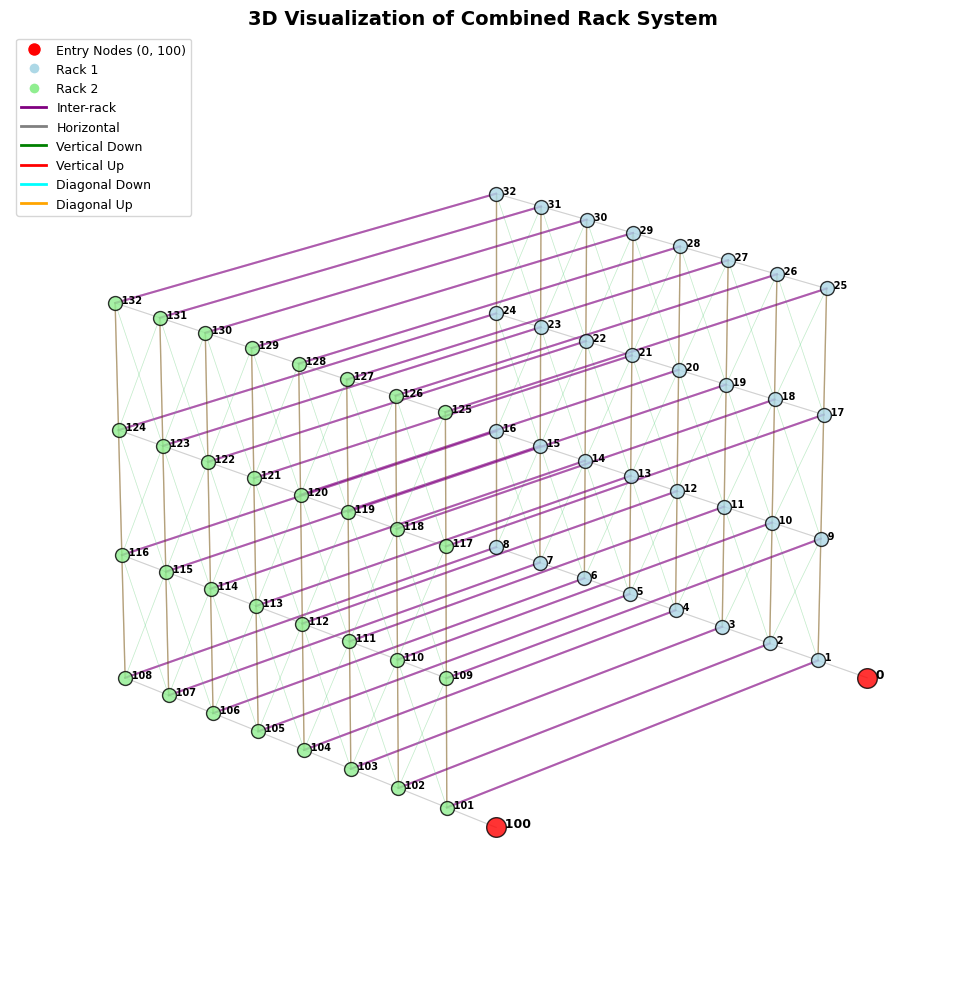

Generating 2D visualization of Rack 1...


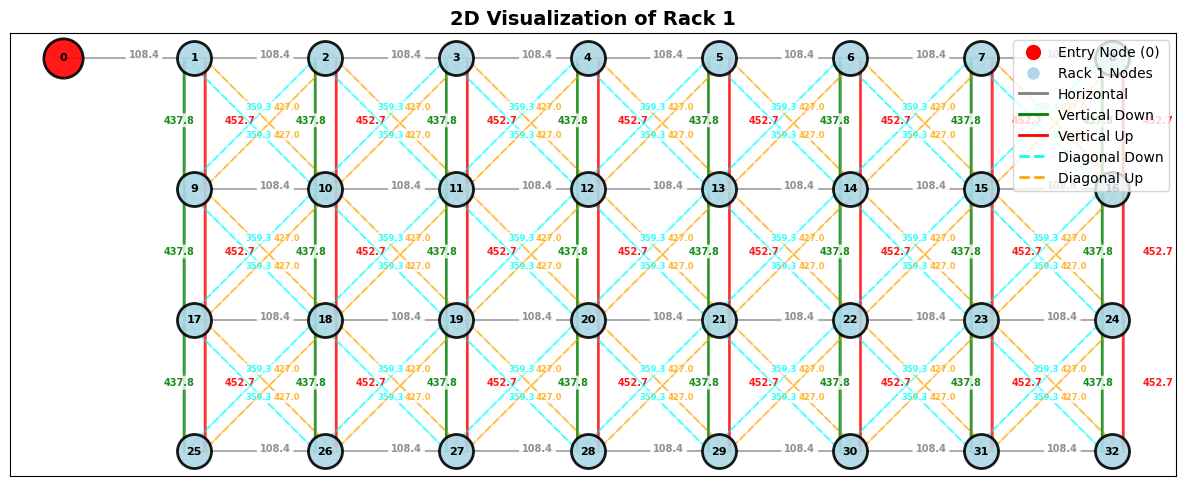

Generating 2D visualization of Rack 2...


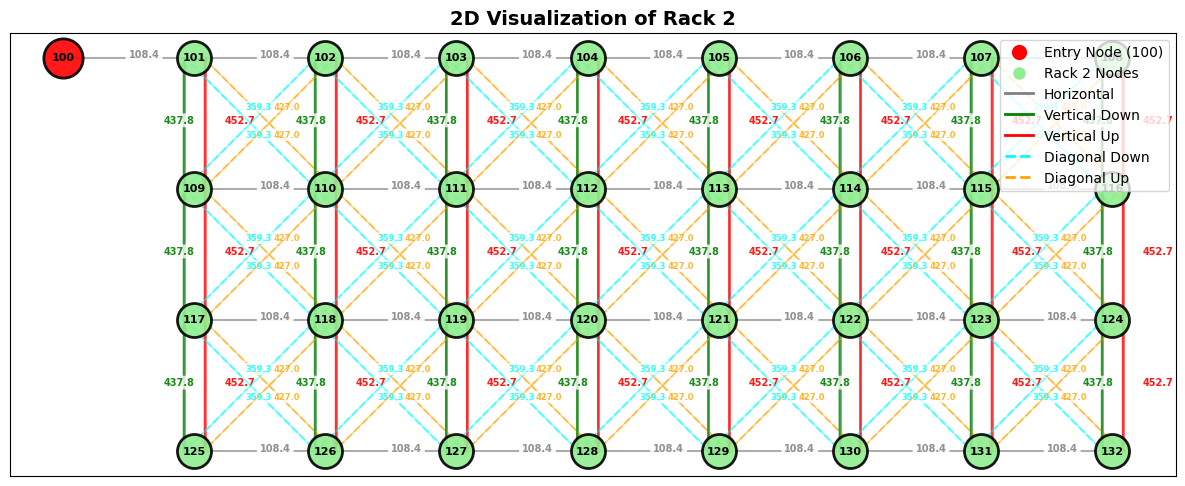

All visualizations generated successfully!


In [30]:
# Generate all visualizations
if __name__ == "__main__":
    # Assuming G_combined exists from your previous code
    # If not, you need to run the rack creation code first
    
    print("Generating 3D visualization of combined system...")
    fig_3d = visualize_3d_combined(G_combined)
    plt.savefig('Intermediate Outputs/rack_3d_combined.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Generating 2D visualization of Rack 1...")
    rack1_nodes = list(range(1, 33))
    G_rack1_view = G_combined.subgraph([0] + rack1_nodes)
    fig_rack1 = visualize_2d_rack(G_rack1_view, 1, rack1_nodes)
    plt.savefig('Intermediate Outputs/rack_2d_rack1.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Generating 2D visualization of Rack 2...")
    rack2_nodes = list(range(101, 133))
    G_rack2_view = G_combined.subgraph([100] + rack2_nodes)
    fig_rack2 = visualize_2d_rack(G_rack2_view, 2, rack2_nodes)
    plt.savefig('Intermediate Outputs/rack_2d_rack2.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("All visualizations generated successfully!")

## Add Properties to Nodes of Network

In this step, the code is added properties which neccessary for calculating the heuristics values in future steps. Basically, we add there postision values (x, y, z) into the nodes.

In [31]:
# Let's convert distance values to cm for calculations
# Physical dimensions (in cm)
CELL_WIDTH = width * 100     # Horizontal distance between nodes (x direction)
CELL_HEIGHT = height * 100     # Vertical distance between nodes (z direction)
AISLE_WIDTH = aisle_width * 100    # Distance between racks (y direction)

### Functions

In [32]:
def add_coordinates_to_combined_graph(G):
    """
    Add physical coordinates to all nodes in the combined graph (G_combined).
    
    Coordinate system:
    - X-axis: Horizontal within rack (0 to 560 cm)
    - Y-axis: Perpendicular to rack face (0 for Rack 1, 280 cm for Rack 2)
    - Z-axis: Vertical height (0 to 480 cm, where 0 is Level 1)
    
    Entry nodes (0, 100) are positioned in front of their respective racks.
    
    Args:
        G: NetworkX DiGraph (G_combined)
    
    Returns:
        Modified graph with coordinates added to all nodes
    """
    for node in G.nodes():
        if node == 0:
            # Entry node for Rack 1 - at rack position
            G.nodes[node]['x'] = 0  # At first column position
            G.nodes[node]['y'] = 0  # At Rack 1 position
            G.nodes[node]['z'] = 0  # Ground level
            G.nodes[node]['rack'] = 1
            G.nodes[node]['row'] = None
            G.nodes[node]['col'] = None
            G.nodes[node]['level'] = 1
            G.nodes[node]['node_type'] = 'entry'
            
        elif node == 100:
            # Entry node for Rack 2 - at rack position
            G.nodes[node]['x'] = 0  # At first column position
            G.nodes[node]['y'] = AISLE_WIDTH  # At Rack 2 position (280 cm)
            G.nodes[node]['z'] = 0  # Ground level
            G.nodes[node]['rack'] = 2
            G.nodes[node]['row'] = None
            G.nodes[node]['col'] = None
            G.nodes[node]['level'] = 1
            G.nodes[node]['node_type'] = 'entry'
            
        else:
            # Regular storage nodes
            rack, row, col = get_position(node)
            
            # Calculate coordinates
            x = col * CELL_WIDTH  # Horizontal position within rack
            z = row * CELL_HEIGHT  # Vertical position (height)
            
            # Y coordinate depends on rack
            if rack == 1:
                y = 0  # Rack 1 at y=0
            else:
                y = AISLE_WIDTH  # Rack 2 at y=280 cm
            
            # Store coordinates and metadata
            G.nodes[node]['x'] = x
            G.nodes[node]['y'] = y
            G.nodes[node]['z'] = z
            G.nodes[node]['rack'] = rack
            G.nodes[node]['row'] = row
            G.nodes[node]['col'] = col
            G.nodes[node]['level'] = row + 1  # Level 1-4 (row 0-3)
            G.nodes[node]['node_type'] = 'storage'
    
    print(f"✓ Coordinates added to {G.number_of_nodes()} nodes in combined graph")
    print(f"  Coordinate ranges:")
    print(f"    X: 0 to {(COLS-1) * CELL_WIDTH} cm")
    print(f"    Y: Rack 1 at 0 cm, Rack 2 at {AISLE_WIDTH} cm")
    print(f"    Z: 0 to {(ROWS-1) * CELL_HEIGHT} cm")
    
    return G

In [33]:
def add_coordinates_to_single_rack(G, rack_num):
    """
    Add physical coordinates to nodes in a single rack graph (G_rack1 or G_rack2).
    
    Coordinate system:
    - X-axis: Horizontal within rack (0 to 560 cm)
    - Y-axis: Always 0 (single rack reference frame)
    - Z-axis: Vertical height (0 to 480 cm, where 0 is Level 1)
    
    Args:
        G: NetworkX DiGraph (G_rack1 or G_rack2)
        rack_num: Rack number (1 or 2)
    
    Returns:
        Modified graph with coordinates added to all nodes
    """
    entry_node = 0 if rack_num == 1 else 100
    
    for node in G.nodes():
        if node == entry_node:
            # Entry node - in front of rack at Level 1
            G.nodes[node]['x'] = 0  # At first column position
            G.nodes[node]['y'] = 0  # Single rack reference frame
            G.nodes[node]['z'] = 0  # Ground level
            G.nodes[node]['rack'] = rack_num
            G.nodes[node]['row'] = None
            G.nodes[node]['col'] = None
            G.nodes[node]['level'] = 1
            G.nodes[node]['node_type'] = 'entry'
            
        else:
            # Regular storage nodes
            rack, row, col = get_position(node)
            
            # Calculate coordinates (y=0 for single rack)
            x = col * CELL_WIDTH  # Horizontal position
            y = 0  # Single rack reference frame
            z = row * CELL_HEIGHT  # Vertical position
            
            # Store coordinates and metadata
            G.nodes[node]['x'] = x
            G.nodes[node]['y'] = y
            G.nodes[node]['z'] = z
            G.nodes[node]['rack'] = rack
            G.nodes[node]['row'] = row
            G.nodes[node]['col'] = col
            G.nodes[node]['level'] = row + 1  # Level 1-4
            G.nodes[node]['node_type'] = 'storage'
    
    print(f"✓ Coordinates added to {G.number_of_nodes()} nodes in Rack {rack_num}")
    print(f"  Coordinate ranges:")
    print(f"    X: 0 to {(COLS-1) * CELL_WIDTH} cm")
    print(f"    Y: 0 cm (single rack reference)")
    print(f"    Z: 0 to {(ROWS-1) * CELL_HEIGHT} cm")
    
    return G

In [34]:
def display_node_info(G, node_id):
    """
    Display all information about a specific node.
    
    Args:
        G: NetworkX graph
        node_id: Node ID to display
    """
    if node_id not in G.nodes():
        print(f"Node {node_id} not found in graph!")
        return
    
    node_data = G.nodes[node_id]
    print(f"\n{'='*50}")
    print(f"NODE {node_id} INFORMATION")
    print(f"{'='*50}")
    
    for key, value in sorted(node_data.items()):
        print(f"  {key:15s}: {value}")
    
    print(f"{'='*50}\n")

def get_nodes_by_level(G, level):
    """
    Get all nodes at a specific level.
    
    Args:
        G: NetworkX graph
        level: Level number (1-4)
    
    Returns:
        List of node IDs at the specified level
    """
    return [n for n in G.nodes() if G.nodes[n].get('level') == level]

def get_nodes_by_rack(G, rack_num):
    """
    Get all nodes in a specific rack.
    
    Args:
        G: NetworkX graph
        rack_num: Rack number (1 or 2)
    
    Returns:
        List of node IDs in the specified rack
    """
    return [n for n in G.nodes() if G.nodes[n].get('rack') == rack_num]

In [35]:
print("="*60)
print("RACK COORDINATE SYSTEM SETUP")
print("="*60)
print(f"\nPhysical Dimensions:")
print(f"  Cell Width:  {CELL_WIDTH} cm")
print(f"  Cell Height: {CELL_HEIGHT} cm")
print(f"  Aisle Width: {AISLE_WIDTH} cm")

add_coordinates_to_combined_graph(G_combined)

add_coordinates_to_single_rack(G_rack1, rack_num=1)
add_coordinates_to_single_rack(G_rack2, rack_num=2)

RACK COORDINATE SYSTEM SETUP

Physical Dimensions:
  Cell Width:  80.0 cm
  Cell Height: 160.0 cm
  Aisle Width: 280.0 cm
✓ Coordinates added to 66 nodes in combined graph
  Coordinate ranges:
    X: 0 to 560.0 cm
    Y: Rack 1 at 0 cm, Rack 2 at 280.0 cm
    Z: 0 to 480.0 cm
✓ Coordinates added to 33 nodes in Rack 1
  Coordinate ranges:
    X: 0 to 560.0 cm
    Y: 0 cm (single rack reference)
    Z: 0 to 480.0 cm
✓ Coordinates added to 33 nodes in Rack 2
  Coordinate ranges:
    X: 0 to 560.0 cm
    Y: 0 cm (single rack reference)
    Z: 0 to 480.0 cm


In [36]:
print(G_combined.nodes[15]['x'], G_combined.nodes[15]['y'], G_combined.nodes[15]['z'])

480.0 0 160.0


## Export the graphs

In [37]:
def export_graph_pickle(G, filename='rack_network.gpickle'):
    """
    Export graph to pickle format (preserves all NetworkX attributes).
    Recommended for Python-to-Python use.
    
    Args:
        G: NetworkX graph
        filename: Output filename (default: 'rack_network.gpickle')
    """
    with open(filename, 'wb') as f:
        pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)
    print(f"Graph exported to {filename}")

In [38]:
base_filename1 = "3d connected network"
export_graph_pickle(G_combined, f"Intermediate Outputs/{base_filename1}.gpickle")

base_filename2 = "rack 1"
export_graph_pickle(G_combined, f"Intermediate Outputs/{base_filename2}.gpickle")

base_filename3 = "rack 2"
export_graph_pickle(G_combined, f"Intermediate Outputs/{base_filename3}.gpickle")

Graph exported to Intermediate Outputs/3d connected network.gpickle
Graph exported to Intermediate Outputs/rack 1.gpickle
Graph exported to Intermediate Outputs/rack 2.gpickle
